In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [ ]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [ ]:
indices = labels_pd.shape[0]
print(indices)

700


In [ ]:
# Shuffle together
labels_pd = labels_pd.sample(frac=1, random_state=17).reset_index(drop=True)
counts_pd = counts_pd.sample(frac=1, random_state=17).reset_index(drop=True)

X = counts_pd.iloc[:, 1:]
y = labels_pd.iloc[:, 1:]

y_sq = y.squeeze() # squeeze one column dataframes

# split training an test sets
split = int(indices * .8)
Xtrain, Xtest = torch.tensor(X.iloc[:split].values, dtype=torch.float32), torch.tensor(X.iloc[split:].values, dtype=torch.float32)
ytrain, ytest = y_sq.iloc[:split].values, y_sq.iloc[split:].values

X = torch.tensor(X.values, dtype=torch.float32)

print(Xtrain.shape)
print(Xtest.shape)

torch.Size([560, 765])
torch.Size([140, 765])


Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [ ]:
import torch.nn.functional as F

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    input_dim = 765
    self.input_layer = nn.Linear(input_dim, 64)
    self.hidden_layer1 = nn.Linear(64, 64)
    self.hidden_layer2 = nn.Linear(64, 32)
    self.output_layer = nn.Linear(32, input_dim)

  def forward(self, x):
    x = self.input_layer(x)
    x = F.relu(x)
    x = self.hidden_layer1(x)
    x = F.relu(x)
    x = self.hidden_layer2(x)
    latent = x
    x = F.relu(x)
    logits = self.output_layer(x)
    return logits, latent

In [ ]:
def l1_reg(latent, l1_weight=1e-5):
    l1_loss = l1_weight * torch.norm(latent, 1)  # L1 norm (sparsity)
    return l1_loss

In [ ]:
def train(model, Xtrain, batch_size, epochs=5):
  batches = Xtrain.shape[0] // batch_size   # using batch_size, determine the number of batches needed
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  loss_fn = nn.MSELoss()

  losses = []

  for epoch in range(epochs):
    for i in range(batches):
        X_batch = Xtrain[i * batch_size: i * batch_size + batch_size]
      
        logits,latent = model.forward(X_batch)
        loss = loss_fn(logits, X_batch)
        loss_withreg = loss_fn(logits, X_batch) + l1_reg(latent)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss)

    # print epoch, loss, and current test accuracy
    print(f"Epoch {epoch}:\tloss {loss} loss+L1:{loss_withreg}")
  torch.save(model.state_dict(), 'model.pth')

  return losses

In [ ]:

model = Encoder()
losses = train(model, Xtrain, batch_size=28, epochs=50)

Epoch 0:	loss 0.9027392268180847 loss+L1:0.9035890698432922
Epoch 1:	loss 0.8884097337722778 loss+L1:0.8899762630462646
Epoch 2:	loss 0.8596163392066956 loss+L1:0.8621332049369812
Epoch 3:	loss 0.8277449607849121 loss+L1:0.8311182856559753
Epoch 4:	loss 0.8031192421913147 loss+L1:0.8070995211601257
Epoch 5:	loss 0.7853080034255981 loss+L1:0.7899502515792847
Epoch 6:	loss 0.7736354470252991 loss+L1:0.7788507342338562
Epoch 7:	loss 0.770548403263092 loss+L1:0.7762889862060547
Epoch 8:	loss 0.7600459456443787 loss+L1:0.7657299041748047
Epoch 9:	loss 0.7584596276283264 loss+L1:0.7633444666862488
Epoch 10:	loss 0.7501110434532166 loss+L1:0.7551425099372864
Epoch 11:	loss 0.7431496381759644 loss+L1:0.7491356730461121
Epoch 12:	loss 0.7361446022987366 loss+L1:0.7425062656402588
Epoch 13:	loss 0.7365787625312805 loss+L1:0.7429102659225464
Epoch 14:	loss 0.7288233637809753 loss+L1:0.7350457906723022
Epoch 15:	loss 0.7231497168540955 loss+L1:0.7293364405632019
Epoch 16:	loss 0.7198451161384583 l

In [ ]:
model = Encoder()
model.load_state_dict(torch.load('model.pth'))

def test(model, batch_size, X_test):
    model.eval()
    batches = Xtest.shape[0] // batch_size
    loss_fn = nn.MSELoss()

    with torch.no_grad():
        for i in range(batches):
          X_batch = X_test[i * batch_size: i * batch_size + batch_size]
          logits,latent = model.forward(X_batch)
          loss = loss_fn(logits, X_batch)
          loss_withreg = loss_fn(logits, X_batch) + l1_reg(latent)
          print(f"loss {loss} loss+L1:{loss_withreg}")

def get_latent_representations(model, X, batch_size):
    model.eval()
    batches = X.shape[0] // batch_size
    latent_vectors = []
    with torch.no_grad():
        for i in range(batches):
          X_batch = X[i * batch_size: i * batch_size + batch_size]
          logits, latent = model.forward(X_batch)
          latent_vectors.append(latent.numpy())
    latent_vectors = np.concatenate(latent_vectors, axis=0)
    print(latent_vectors.shape)
    return latent_vectors

In [ ]:
test(model, 28, Xtest)

latent_vec = get_latent_representations(model, X, 20)

loss 0.8611610531806946 loss+L1:0.867780327796936
loss 0.8156139850616455 loss+L1:0.8223072290420532
loss 0.8049623966217041 loss+L1:0.811497151851654
loss 0.907326877117157 loss+L1:0.915090024471283
loss 0.7479658126831055 loss+L1:0.7546482682228088
(700, 32)


Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

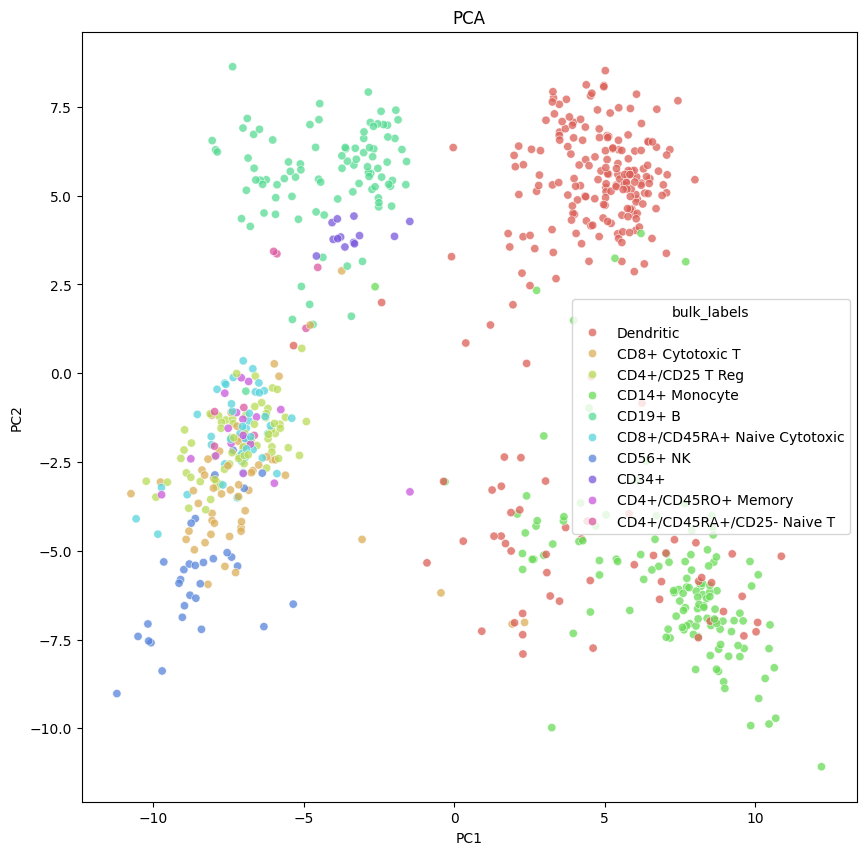

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
            hue=y_sq,
            palette=sns.color_palette("hls", 10),
            legend="full",
            alpha=0.75)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
plt.show()

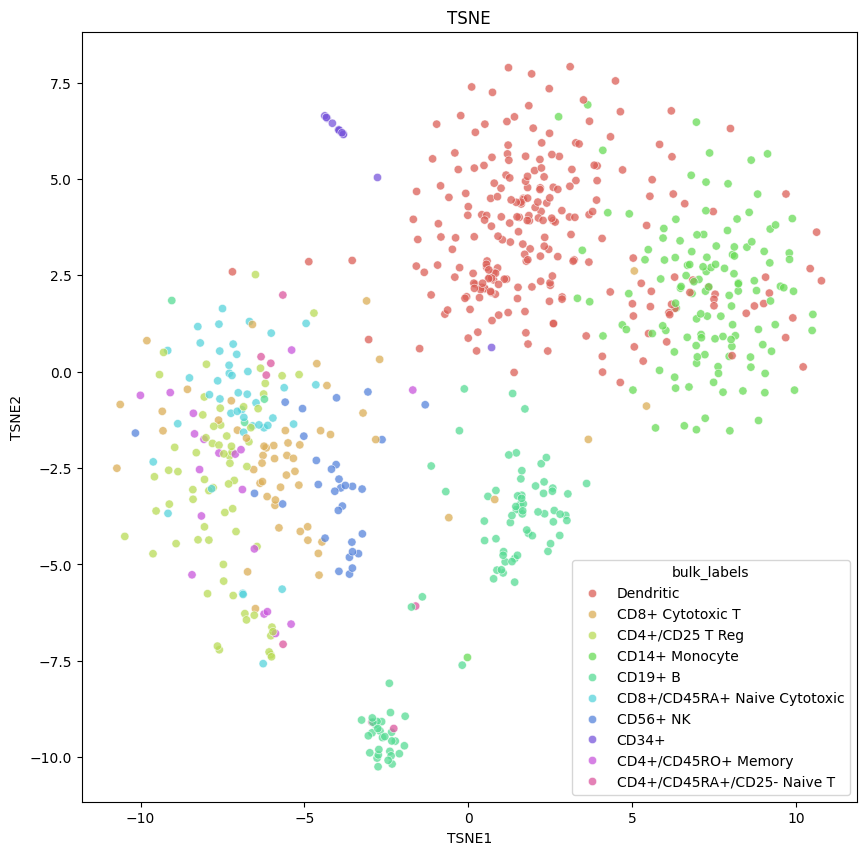

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)


plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
            hue=y_sq,
            palette=sns.color_palette("hls", 10),
            legend="full",
            alpha=0.75)
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.title("TSNE")
plt.show()

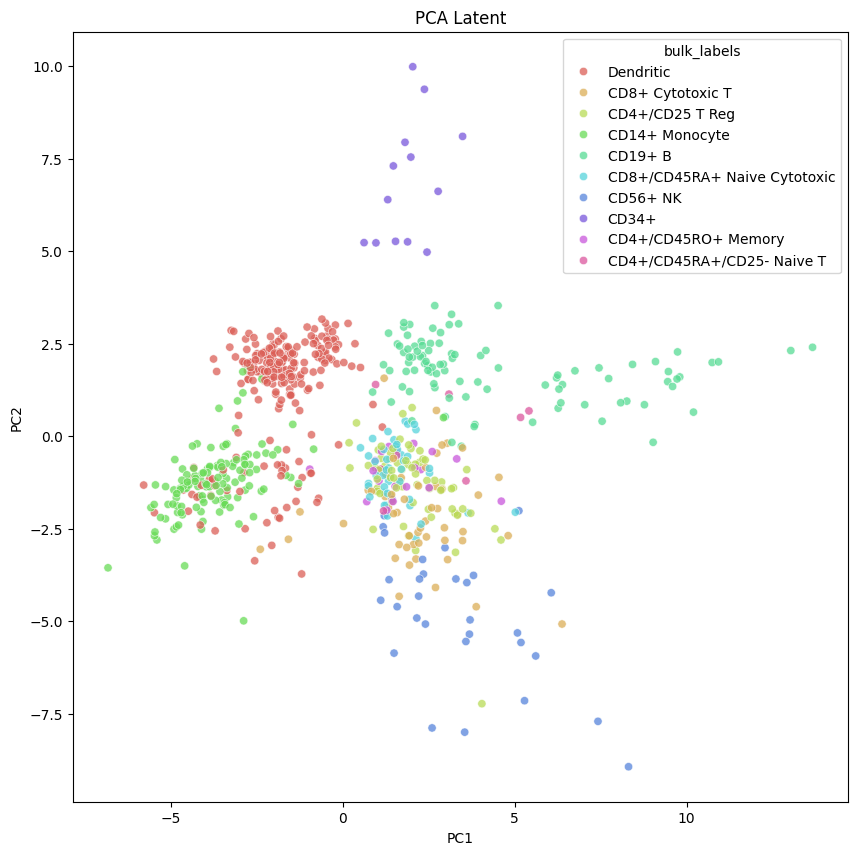

In [ ]:
pca_latent = PCA(n_components=2)
X_latent = pca_latent.fit_transform(latent_vec)
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_latent[:, 0], y=X_latent[:, 1],
                hue=y_sq,
                palette=sns.color_palette("hls", 10),
                legend="full",
                alpha=0.75)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Latent")
plt.show()

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.